# Language Translator 

## Sequence-to-sequence learning

### A machine translation example

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Bidirectional,GRU,LSTM,Embedding
from tensorflow.keras.layers import Dense,MultiHeadAttention,LayerNormalization,Embedding,Dropout,Layer
from tensorflow.keras import Sequential,Input

In [2]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


Each line contains an English sentence and its corresponding Spanish sentence. The English sentence is the source sequence and Spanish one is the target sequence. We prepend the token "[start]" and we append the token "[end]" to the Spanish sentence.

In [3]:
#text_file = "../input/eng-spanish/spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [4]:
import random
print(random.choice(text_pairs))

('She pleaded with him to stay a little bit longer.', '[start] Ella le rogó que se quedase un poquito más. [end]')


In [5]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

## **Vectorizing the English and Spanish text pairs**

**Text Cleaning**

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

**Text Standardization**
* Convert Text to lowercase

In [7]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

### Text Vectorization

We'll use two instances of the TextVectorization layer to vectorize the text data (one for English and one for Spanish), that is to say, to turn the original strings into integer sequences where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters) and splitting scheme (split on whitespace), while the Spanish layer will use a custom standardization, where we add the character "¿" to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend stripping the punctuation characters in either language. Instead, I would recommend turning each punctuation character into its own token, which you could achieve by providing a custom split function to the TextVectorization layer.

In [8]:
vocab_size = 15000
sequence_length = 20

source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

2022-10-11 14:39:51.481082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:39:51.579625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:39:51.580492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-11 14:39:51.582208: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Preparing datasets for the translation task**

In [9]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [10]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


2022-10-11 14:40:06.580899: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Sequence-to-sequence learning with RNNs

**GRU-based encoder**

In [11]:
embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = Bidirectional(GRU(latent_dim), merge_mode="sum")(x)

**GRU-based decoder and the end-to-end model**

In [12]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_GRU = GRU(latent_dim, return_sequences=True)
x = decoder_GRU(x, initial_state=encoded_source)
x = Dropout(0.5)(x)
target_next_step = Dense(vocab_size, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

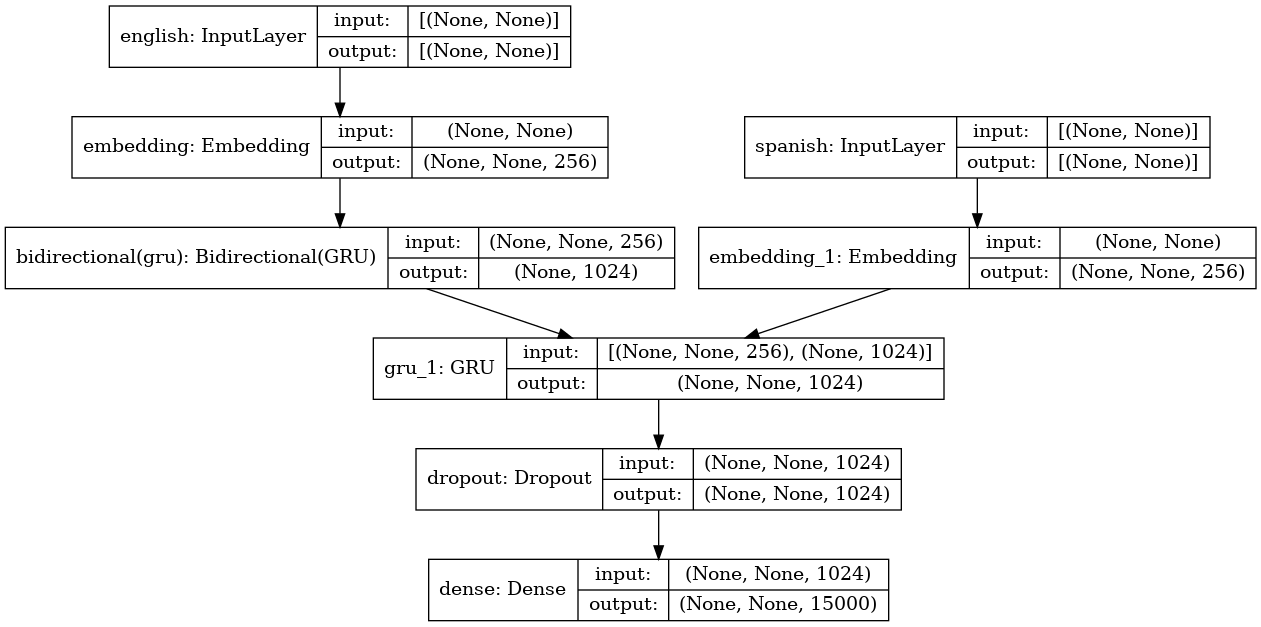

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(seq2seq_rnn, to_file='seq2seq_rnn.png', show_shapes=True)
from IPython.display import Image
Image("seq2seq_rnn.png")

**Training our recurrent sequence-to-sequence model**

In [14]:
EPOCHS = 30
seq2seq_rnn.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=EPOCHS,batch_size=256, validation_data=val_ds)

Epoch 1/30


2022-10-11 14:40:22.425061: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1302/1302 [==============================] - 117s 81ms/step - loss: 1.6299 - accuracy: 0.4188 - val_loss: 1.3285 - val_accuracy: 0.5015
Epoch 2/30
1302/1302 [==============================] - 102s 78ms/step - loss: 1.3124 - accuracy: 0.5280 - val_loss: 1.1594 - val_accuracy: 0.5664
Epoch 3/30
1302/1302 [==============================] - 102s 78ms/step - loss: 1.1716 - accuracy: 0.5770 - val_loss: 1.0759 - val_accuracy: 0.5990
Epoch 4/30
1302/1302 [==============================] - 102s 78ms/step - loss: 1.0797 - accuracy: 0.6094 - val_loss: 1.0401 - val_accuracy: 0.6192
Epoch 5/30
1302/1302 [==============================] - 102s 78ms/step - loss: 1.0340 - accuracy: 0.6332 - val_loss: 1.0260 - val_accuracy: 0.6288
Epoch 6/30
1302/1302 [==============================] - 102s 78ms/step - loss: 1.0035 - accuracy: 0.6523 - val_loss: 1.0220 - val_accuracy: 0.6351
Epoch 7/30
1302/1302 [==============================] - 101s 78ms/step - loss: 0.9839 - accuracy: 0.6655 - val_loss: 1.0220 - val

In [15]:
!mkdir -p saved_model
seq2seq_rnn.save('saved_model/seq2seq_rnn')

2022-10-11 15:41:11.278916: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


**Translating new sentences with our RNN encoder and decoder**

In [16]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

In [17]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

### Sequence to Sequence RNN - Translation Output

In [18]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
You may kiss the bride.
[start] puedes [UNK] a la cama [end]
-
Does anyone want some more pie?
[start] alguien quiere más de un poco de más [end]
-
I was waiting for you.
[start] te estaba esperando [end]
-
Tom and I got into a fight.
[start] tom y yo me a la estación [end]
-
I think Tom is acting a little suspicious.
[start] creo que tom está un poco de comer [UNK] [end]
-
What does she do in the summer?
[start] qué hace ella en el verano [end]
-
She's turning red.
[start] ella está [UNK] de su cuando un poco de la [UNK] de tu parte [end]
-
She is wrong.
[start] ella está equivocado [end]
-
You must hurry up.
[start] debes [UNK] [end]
-
I don't have time to write.
[start] no tengo tiempo para que no lo a escribir [end]
-
Do you think we should import rice from the U.S.?
[start] crees que nos gustaría tener que [UNK] el [end]
-
I'm really not hungry.
[start] no tengo hambre [end]
-
He has a nice income.
[start] tiene un par de [UNK] [end]
-
What time does your plane leave?
[start] a 

### Sequence-to-sequence learning with Transformer

## Transformer Encoder

In [19]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential(
            [Dense(dense_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

#### The Transformer decoder

**The `TransformerDecoder`**

In [20]:
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [Dense(dense_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### A Transformer for machine translation

**PositionalEmbedding layer**

In [21]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [22]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = Dropout(0.5)(x)
decoder_outputs = Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

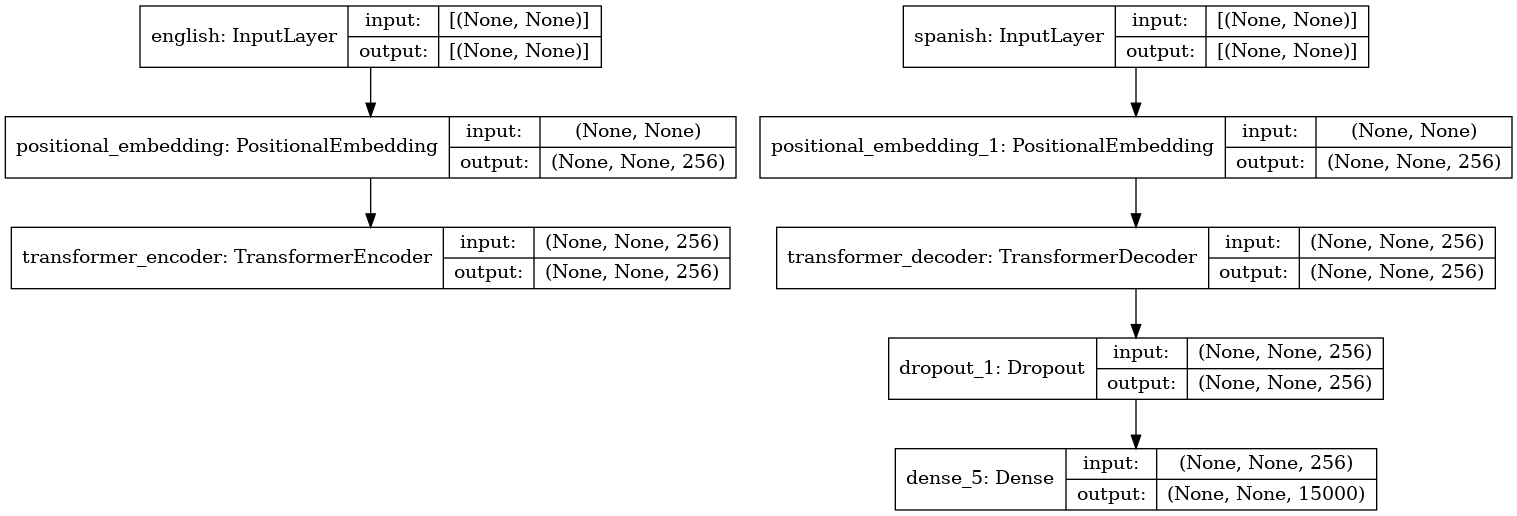

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(transformer, to_file='transformer.png', show_shapes=True)
from IPython.display import Image
Image("transformer.png")

**Training the sequence-to-sequence Transformer**

In [24]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/30
1302/1302 [==============================] - 93s 69ms/step - loss: 1.6839 - accuracy: 0.4157 - val_loss: 1.3249 - val_accuracy: 0.5090
Epoch 2/30
1302/1302 [==============================] - 89s 68ms/step - loss: 1.3520 - accuracy: 0.5283 - val_loss: 1.1736 - val_accuracy: 0.5678
Epoch 3/30
1302/1302 [==============================] - 89s 68ms/step - loss: 1.1990 - accuracy: 0.5772 - val_loss: 1.0909 - val_accuracy: 0.5971
Epoch 4/30
1302/1302 [==============================] - 89s 68ms/step - loss: 1.1074 - accuracy: 0.6103 - val_loss: 1.0448 - val_accuracy: 0.6233
Epoch 5/30
1302/1302 [==============================] - 89s 68ms/step - loss: 1.0574 - accuracy: 0.6329 - val_loss: 1.0226 - val_accuracy: 0.6333
Epoch 6/30
1302/1302 [==============================] - 89s 68ms/step - loss: 1.0235 - accuracy: 0.6499 - val_loss: 1.0075 - val_accuracy: 0.6411
Epoch 7/30
1302/1302 [==============================] - 89s 68ms/step - loss: 0.9986 - accuracy: 0.6632 - val_loss: 0.9995 -

In [25]:
!mkdir -p saved_model
transformer.save('trans_model/transformer')

**Translating new sentences with our Transformer model**

In [26]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

In [27]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

### Transformer translating output

In [28]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
My head is spinning.
[start] me duele la cabeza [end]
-
Why don't you go play outside?
[start] por qué no vas a ir fuera [end]
-
Is it Tuesday already?
[start] ya es el examen [end]
-
She will without a doubt visit England this summer.
[start] ella vendrá sin propósito para que el verano [end]
-
I ran into my teacher just as I left the store.
[start] yo me encontré en mi profesor solo [end]
-
Where did you go with Tom?
[start] con dónde fue tom [end]
-
He wanted it to be a surprise.
[start] quería que fuera una sorpresa [end]
-
Tom is a doctor now.
[start] tom es un doctor ahora [end]
-
I hurried so I wouldn't miss the train.
[start] me [UNK] así que no voy a perder el tren [end]
-
That's quite absurd.
[start] eso es bastante a los de los de [UNK] [end]
-
Get a hammer and nails.
[start] [UNK] algunos de a los de [UNK] [end]
-
He told me that his father was a doctor.
[start] Él me dijo que su padre era doctor [end]
-
Tom went along with the scheme.
[start] tom se fue a causa del plan 

## Summary

* Thus Transformer model is implemented for translating Spanish to English.
* BLEU score is the metrics used to evaluate the performance of the tranformer in translating the language.